# Задача регрессии

Бизнес-задача: определить характеристики и с их помощью спрогнозировать длительность поездки такси.

Техническая задача: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

Основные цели проекта:
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных



### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from scipy.stats import normaltest
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
import xgboost as xgb

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Первичная обработка данных

In [2]:
# Прочитаем файл с исходными данными
taxi_data = pd.read_csv("data/train.csv")
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Посмотрим на временные рамки, в которых мы работаем с данными
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(taxi_data['pickup_datetime'].max(), taxi_data['pickup_datetime'].min())

2016-06-30 23:59:39 2016-01-01 00:00:17


In [4]:
# Проверим датасет на наличие пропущенных значений
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [5]:
# Посмотрим статистические характеристики признаков
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


### Feature Engineering

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Напишем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездкахи возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.


In [6]:
# Создаем функцию
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

In [7]:
# Применим функцию к данным
add_datetime_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5


Напишем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 


In [8]:
# Прочитаем данные о праздничных днях
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'])
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])

In [9]:
# Создадим функцию
def add_holiday_features(taxi, holiday):
    taxi = taxi.merge(holiday[['date']], how='left', left_on='pickup_date', right_on='date')
    taxi = taxi.fillna({'date':0})
    taxi['pickup_holiday'] = taxi['date'].apply(lambda x: 0 if x==0  else 1)
    taxi_new = taxi.drop(['date'], axis=1)
    return taxi_new

In [10]:
# Применим функцию к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0


Напишем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.


In [11]:
# Прочитаем данные из OSRM
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [12]:
# Создадим функцию
def add_osrm_features(taxi, osrm):
    osrm_data = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_new = taxi.join(osrm_data.set_index('id'), how='left', on='id')
    return taxi_new

In [13]:
# Применим функцию к данным
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


Напишем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Для этого предварительно напишем функции для рассчета расстояния по формуле Хаверсина и угла направления движения.

In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [15]:
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(
        data['pickup_latitude'], data['pickup_longitude'], 
        data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(
        data['pickup_latitude'], data['pickup_longitude'], 
        data['dropoff_latitude'], data['dropoff_longitude'])
    return data

In [16]:
# Применим функцию к данным
taxi_data = add_geographical_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585


Напишем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [17]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((
    taxi_data[['pickup_latitude', 'pickup_longitude']],
    taxi_data[['dropoff_latitude', 'dropoff_longitude']]
    ))
# Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=36)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=36)

In [18]:
# Создадим функцию
def add_cluster_features(data):
    coords = np.hstack((
        data[['pickup_latitude', 'pickup_longitude']],
        data[['dropoff_latitude', 'dropoff_longitude']]
        ))
    kmeans = cluster.KMeans(n_clusters=10, random_state=36)
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.labels_
    return data

In [19]:
# Применим функцию к данным
taxi_data = add_cluster_features(taxi_data)
taxi_data['geo_cluster'].value_counts()

7    592223
8    392800
2    339659
4     45540
0     40239
3     32793
9     15365
6        18
5         5
1         2
Name: geo_cluster, dtype: int64

Напишем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.



In [20]:
# Прочитаем данные о погодных условиях и оставим нужные признаки
weather_data = pd.read_csv('data/weather_data.csv')
cols_to_drop = ['windchill', 'heat index', 'humidity', 'pressure', 'dew Point', 'wind dir', 'gust speed', 'conditions', 'time']
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data.drop(cols_to_drop, axis=1)

In [21]:
# Создадим функцию
def add_weather_features(taxi, weather):
    taxi = taxi.merge(weather, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date','hour'])
    data_new = taxi.drop(['date','hour'], axis=1)
    return data_new

In [22]:
# Применим функцию к данным
taxi_data = add_weather_features(taxi_data, weather_data)

Напишем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполняем медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. 
Пропуски в столбце events заполняем строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 
Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполняем медианным значением по столбцам. 



In [23]:
# Создадим функцию
def fill_null_weather_data(data):
    grouped = data.groupby('pickup_date').median()
    values = {'temperature':grouped['temperature'].median(),\
                'visibility':grouped['visibility'].median(),\
                'wind speed':grouped['wind speed'].median(),\
                'precip':grouped['precip'].median(),\
                'events':'None',\
                'total_distance':data['total_distance'].median(),\
                'total_travel_time':data['total_travel_time'].median(),\
                'number_of_steps':data['number_of_steps'].median()}
    data_new = data.fillna(values)
    return data_new

In [24]:
# Применим функцию к данным
taxi_data = fill_null_weather_data(taxi_data)
taxi_data.isnull().sum()

C:\Users\Anna\AppData\Local\Temp\ipykernel_27136\3446683730.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = data.groupby('pickup_date').median()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

Очистим датасет от выбросов по целевой переменной (длительность поездки)

Найдем слишком продолжительные поездки, длительность которых превышает 24 часа.
А также поездки со значительной средней скоростью (превышает 300 км/ч). Удалим эти выбросы.

Построим диаграмму рассеяния средней скорости движения автомобилей:


Text(0, 0.5, 'Average speed')

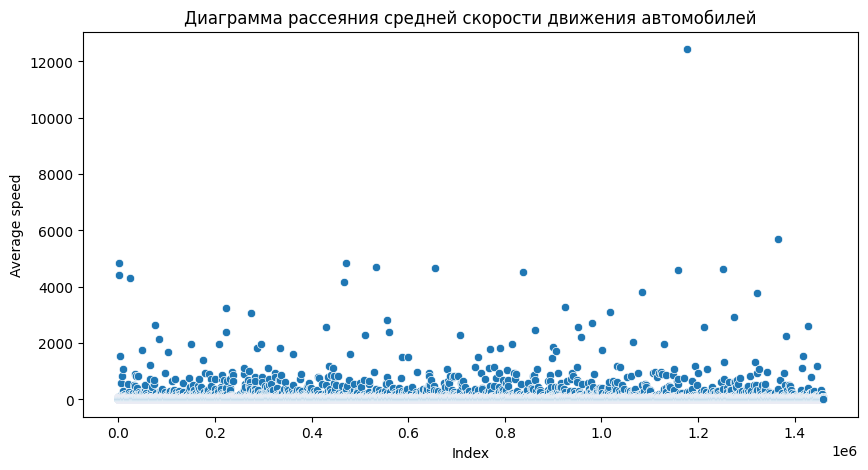

In [25]:
# Рассчитаем среднюю скорость поездки
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
# Построим график
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_title('Диаграмма рассеяния средней скорости движения автомобилей')
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

На графике видно, что выбросы присутствуют.
Напишем функции outliers_duration() для очищения датасета от выбросов по длительности и outliers_speed() - по скорости.

In [26]:
def outliers_duration(data, feature, limit):
    x = data[feature]/3600
    outliers = data[x>limit]
    data_new = data[x<=limit]
    return outliers, data_new

# Применим функцию к данным
out_d, taxi_data = outliers_duration(taxi_data, 'trip_duration', 24)

In [27]:
def outliers_speed(data, limit):
    x = data['total_distance'] / data['trip_duration'] * 3.6
    outliers = data[x>limit]
    cleaned = data[x<=limit]
    return outliers, cleaned

# Применим функцию к данным
out_s, taxi_data = outliers_speed(taxi_data, 300)

### Разведывательный анализ данных (EDA)

На этапе машинного обучения основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака.


In [28]:
# Логарифмируем целевой признак
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе для визуальной оценки распределения признака. А также проведем тест на нормальность Д’Агостино при уровне значимости 0.05 


Text(0.5, 0, 'Продолжительность поездки')

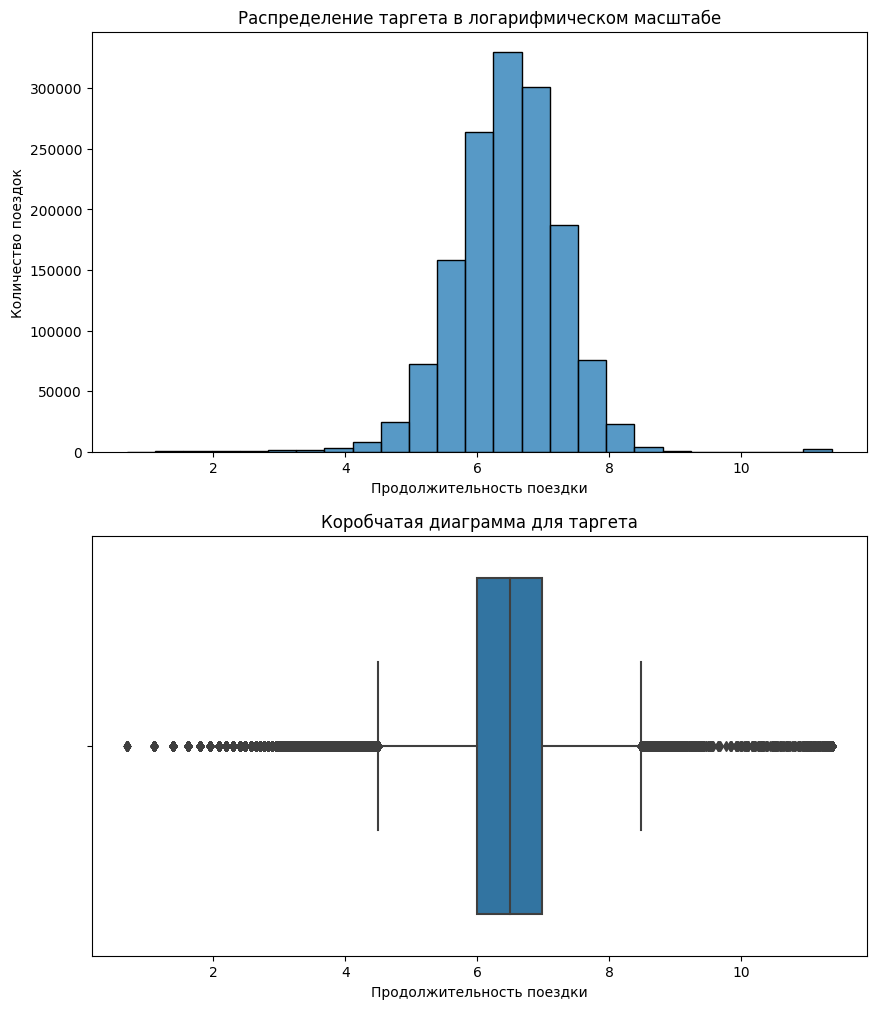

In [29]:
# Гистограмма и коробчатая диаграмма для целевого признака
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
sns.histplot(taxi_data, x='trip_duration_log', bins=25, ax=axes[0])
sns.boxplot(taxi_data, x='trip_duration_log', ax=axes[1])
axes[0].set_title('Распределение таргета в логарифмическом масштабе')
axes[0].set_xlabel('Продолжительность поездки')
axes[0].set_ylabel('Количество поездок')
axes[1].set_title('Коробчатая диаграмма для таргета')
axes[1].set_xlabel('Продолжительность поездки')

In [30]:
# тест Д’Агостино
# Формулируем гипотезы
H0 = 'Распределение целевого признака нормальное'
H1 = 'Распределение отлично от нормального'
# Уровень значимости
alpha = 0.05
stat, p = normaltest(taxi_data['trip_duration_log'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Проверяем гипотезы
if p > alpha:
	print('Невозможно опровергнуть нулевую гипотезу:', H0)
else:
	print('Отвергаем нулевую гипотезу:', H1)

Statistics=138350.166, p=0.000
Отвергаем нулевую гипотезу: Распределение отлично от нормального


Несмотря на то, что тест показал, что распределение целевого признака не является нормальным, судя по графику, к нормальному оно близко.
Построим гистограмму, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка (vendor_id) и сравним их между собой.

Text(0, 0.5, 'Количество поездок')

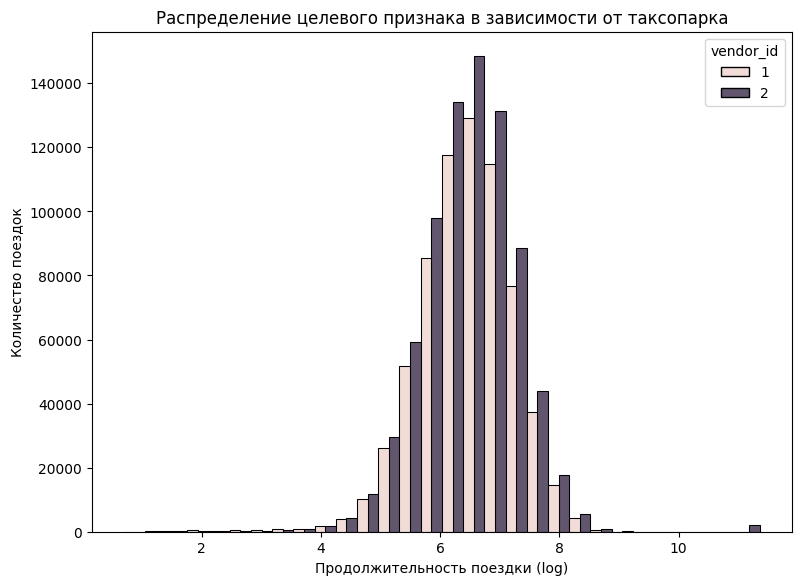

In [31]:
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', multiple='dodge', bins=30, ax=ax)
ax.set_title('Распределение целевого признака в зависимости от таксопарка')
ax.set_xlabel('Продолжительность поездки (log)')
ax.set_ylabel('Количество поездок')

На графике видно, что между различными таксопарками распределение продолжительности поездки существенно не отличается. Поэтому данный признак не оказывает существенного влияния на таргет

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.


Text(0, 0.5, 'Количество поездок')

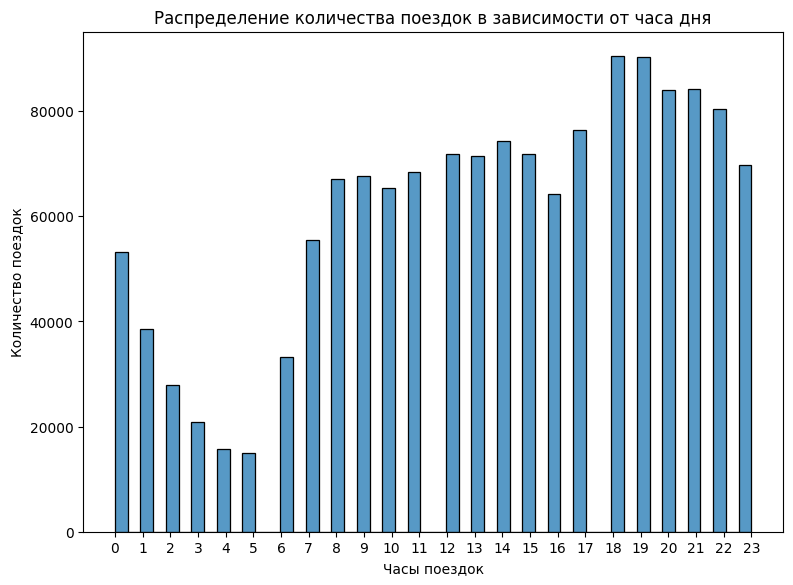

In [32]:
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.histplot(taxi_data, x='pickup_hour', bins=50, ax=ax)
ax.set_xticks(list(range(0,24)))
ax.set_title('Распределение количества поездок в зависимости от часа дня')
ax.set_xlabel('Часы поездок')
ax.set_ylabel('Количество поездок')

Text(0, 0.5, 'Продолжительность поездки')

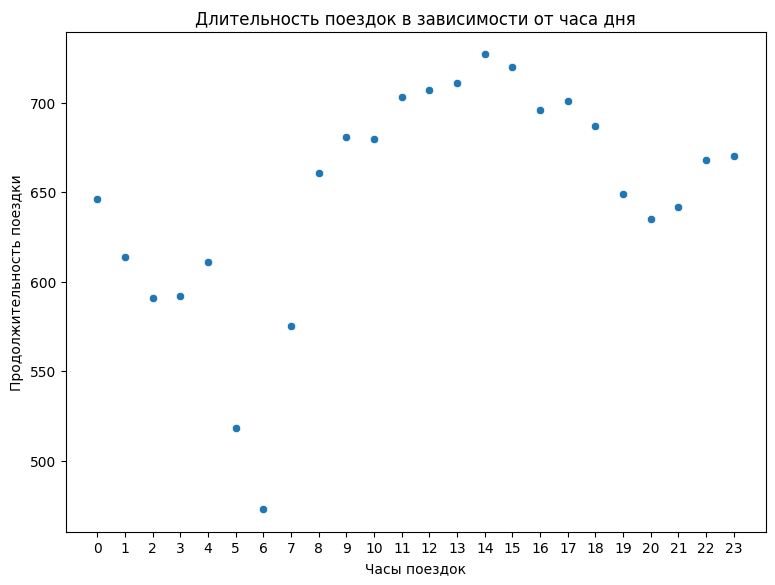

In [33]:
# Формируем выборку для визуализации
data = taxi_data[['pickup_hour', 'trip_duration']]
pivot = data.groupby('pickup_hour')['trip_duration'].median()
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.scatterplot(pivot, ax=ax)
ax.set_xticks(list(range(0,24)))
ax.set_title('Длительность поездок в зависимости от часа дня')
ax.set_xlabel('Часы поездок')
ax.set_ylabel('Продолжительность поездки')


Как показали графики, количество поездок и их продолжительность связаны с фактором времени суток. Минимальное количество поездок приходится на 5 часов утра, а максимальное - на промежуток 18-19 часов. Длительность (целевой признак) минимальна в 5-6 утра, а вот для долгих поездок люди выбирают дневное время с 11 до 15 часов. Это говорит о том, что признак времени суток является значимым для прогнозирования продолжительности поездки.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

Text(0, 0.5, 'Медианная длительность поездки')

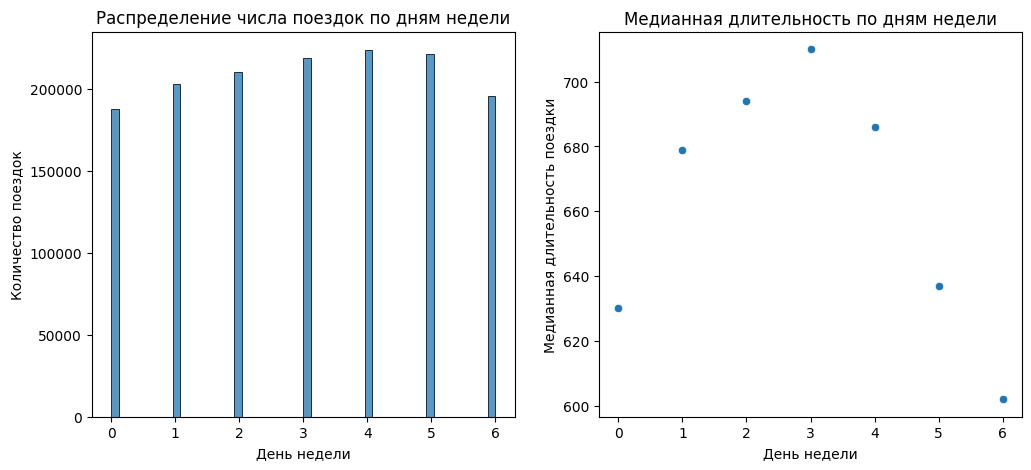

In [34]:
# Формируем выборку для визуализации
data = taxi_data[['pickup_day_of_week', 'trip_duration']]
pivot = data.groupby('pickup_day_of_week')['trip_duration'].median()
# Строим график
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
sns.histplot(taxi_data, x='pickup_day_of_week', bins=50, ax=axes[0])
sns.scatterplot(pivot, ax=axes[1])
axes[0].set_title('Распределение числа поездок по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')
axes[1].set_title('Медианная длительность по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медианная длительность поездки')

Как мы видим, количество рейсов незначительно отличается по дням недели. В выходные поездок чуть меньше, но их число соизмеримо с будними днями. Однако, продолжительность поездок показывает другую картину. Максимальная длительность приходится на середину недели, а в выходные заметно падает. Поэтому для целевой переменной фактор дня недели тоже имеет значение.

Посмотрим на обе временные характеристики на одном графике. Построим сводную таблицу, по строкам которой отложены часы, по столбцам - дни недели, а в ячейках - медианная длительность поездки. Визуализируем полученную сводную таблицу с помощью тепловой карты.

Text(670.7222222222223, 0.5, 'Часы дня')

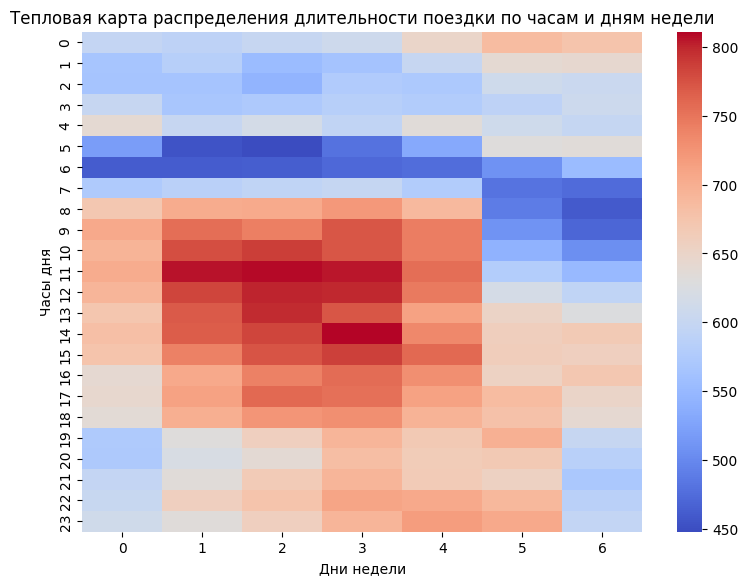

In [35]:
# Формируем сводную таблицу для визуализации
data = taxi_data[['pickup_hour', 'pickup_day_of_week', 'trip_duration']]
pivot = data.pivot_table(values='trip_duration', aggfunc='median', columns='pickup_day_of_week', index='pickup_hour')
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.heatmap(pivot, cmap='coolwarm', ax=ax)
ax.set_title('Тепловая карта распределения длительности поездки по часам и дням недели')
ax.set_xlabel('Дни недели')
ax.set_ylabel('Часы дня')

На тепловой карте видно отчетливую область пиковых значений таргета. Минимальная продолжительность поездки приходится на 5-6 часов утра в начале рабочей недели, а максимальная - на 10-15 часов дня также с понедельника по среду. Это показывает четкую картинураспределения таргета по временным признакам и позволяет спрогнозировать длительность поездки на такси.

### Отбор и преобразование признаков

Тестовая выборка содержится в отдельном файле, поэтому для обучения моделей скопируем этот датасет и присвоим ему имя train_data. 

In [36]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,8,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,2,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,2,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,2,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,8,9.4,16.1,9.3,0.0,None,6.077642


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков. Удалим также неинформативный признак id и создающий утечку данных признак dropoff_datetime.

In [37]:
# Удаляем столбцы
train_data = train_data.drop(['pickup_datetime', 'pickup_date', 'id','dropoff_datetime'], axis=1)

Закодируем признак vendor_ida таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.
Закодируем признак store_and_fwd_flag таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.

In [38]:
# Кодируем признаки
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и eventsс помощью OneHotEndoder из библиотеки sklearn.
В результате работы OneHotEncoder получаем безымянный numpy-массив, который преобразуем обратно в DataFrame, для более удобной работы в дальнейшем.


In [39]:
encoder = preprocessing.OneHotEncoder(drop='first')
columns_to_change = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]
# Кодируем данные
data_onehot = encoder.fit_transform(columns_to_change).toarray()
column_names = encoder.get_feature_names_out()
# Формируем датафрейм
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

Добавим полученную таблицу с закодированными признаками:

In [40]:
# Присоединяем таблицу
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log.

In [41]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Разобьем выборку на обучающую и валидационную в соотношении 70/30:

In [42]:
# Разбиваем данные на тренировочную и валидационную выборки
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.3, 
    random_state=36
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.
С помощью SelectKBest отбираем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. 

In [43]:
# Производим отбор k признаков с помощью SelectKBest
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
# Имена отобранных столбцов
feature_names = selector.get_feature_names_out()
feature_names

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_3', 'geo_cluster_4',
       'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9'], dtype=object)

In [44]:
# Формируем выборки из отобранных столбцов
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler


In [45]:
# Нормализуем данные
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

### Линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. В качестве метрики использовать RMSLE (Root Mean Squared Log Error).
Логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе.

In [46]:
# Напишем функцию для вычисления метрики
def rmsle(y, y_pred):
    rmsle = metrics.mean_squared_error(y, y_pred)**0.5
    return rmsle

В качестве baseline будем использовать модель линейной регрессии (LinearRegression) с параметрами по умолчанию.

In [47]:
# Создаем и обучаем модель
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train_log)
# Делаем предсказание и вычисляем метрику
y_pred_valid = model.predict(X_valid_scaled)
l_reg = round(rmsle(y_valid_log, y_pred_valid), 2)
print(f'RMSLE: {l_reg}')

RMSLE: 0.53


Попробуем улучшить качество модели с использованием полиномиальной регрессии

In [48]:
# Создаем полиномиальные признаки 2 степени
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
# Преобразуем данные
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)
# Создаем и обучаем модель на новых признаках
model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train_log)
# Делаем предсказание и вычисляем метрику
y_pred_valid = model.predict(X_valid_poly)
poly_reg = round(rmsle(y_valid_log, y_pred_valid), 2)
print(f'RMSLE: {poly_reg}')

RMSLE: 0.47


Ошибку удалось уменьшить и повысить качество модели.

Построим модель дерева решений (DecisionTreeRegressor), подобрав оптимальную глубину с помощью optuna. Затем обучим ее и вычислим метрику.

In [49]:
def optuna_dt(trial):
  # Задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 5, 20, 1)
  # Создаем модель
  model = tree.DecisionTreeRegressor(
    max_depth=max_depth, 
    random_state=36
    )
  # Обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = rmsle(y_valid_log, model.predict(X_valid_scaled))

  return score

In [50]:
study = optuna.create_study(study_name="DecisionTreeRegressor", direction="minimize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_dt, n_trials=20)

[I 2023-11-22 17:04:21,898] A new study created in memory with name: DecisionTreeRegressor


[I 2023-11-22 17:04:43,725] Trial 0 finished with value: 0.4376830409984347 and parameters: {'max_depth': 14}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:05:03,397] Trial 1 finished with value: 0.4439415100106311 and parameters: {'max_depth': 15}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:05:26,818] Trial 2 finished with value: 0.4612350113280765 and parameters: {'max_depth': 17}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:05:33,703] Trial 3 finished with value: 0.46945083673423127 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:05:42,522] Trial 4 finished with value: 0.45560798076718456 and parameters: {'max_depth': 6}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:06:01,182] Trial 5 finished with value: 0.4376830409984347 and parameters: {'max_depth': 14}. Best is trial 0 with value: 0.4376830409984347.
[I 2023-11-22 17:06:21,202] Trial 6 finished w

In [51]:
# Выведем результаты
print('best params', study.best_params)
print('best score:', round(study.best_value, 2))

best params {'max_depth': 11}
best score: 0.43


In [52]:
# Создаем модель и обучаем ее
model = tree.DecisionTreeRegressor(**study.best_params, random_state=36)
model.fit(X_train_scaled, y_train_log)
# Делаем предсказание и вычисляем метрику
y_pred_valid = model.predict(X_valid_scaled)
dt = round(rmsle(y_valid_log, y_pred_valid), 2)
print(f'RMSLE: {dt}')

RMSLE: 0.43


Дерево решений справилось с предсказанием длительности поездки лучше, ошибку удалось уменьшить

### Ансамблевые методы

Построим модель случайного леса (RandomForestRegressor)

In [53]:
# Создадим модель случайного леса
model = ensemble.RandomForestRegressor(
    n_estimators=100,
    max_depth=11, 
    criterion='squared_error', 
    random_state=36
    )
# Обучаем модель и вычисляем метрику
model.fit(X_train_scaled, y_train_log)
y_pred_valid = model.predict(X_valid_scaled)
rf = round(rmsle(y_valid_log, y_pred_valid), 2)
print(f'RMSLE: {rf}')

RMSLE: 0.42


Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) 
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [54]:
# Создадим модель градиентного бустинга
model = ensemble.GradientBoostingRegressor(
    n_estimators=100, 
    max_depth=6, 
    min_samples_split=30, 
    random_state=36,
    learning_rate=0.5
    )
# Обучаем модель и вычисляем метрику
model.fit(X_train_scaled, y_train_log)
y_pred_valid = model.predict(X_valid_scaled)
gr_boo = round(rmsle(y_valid_log, y_pred_valid), 2)
print(f'RMSLE: {gr_boo}')

RMSLE: 0.39


Градиентный бустинг справился лучше. Построим модель экстремального градиентного бустинга над деревьями решений (XGBoost).
Перед обучением переведем наборы данных в тип данных xgboost.DMatrix.

In [55]:
# Создадим матрицы наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names)
# Зададим гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель
model = xgb.train(
    params=xgb_pars,
    dtrain=dtrain, 
    num_boost_round=300, 
    evals=watchlist,
    early_stopping_rounds=20,
    maximize=False,
    verbose_eval=20 
)
# Вычисляем метрику
xgb_score = round(model.best_score, 2)
print('RMSLE: %.2f' % xgb_score)

[0]	train-rmse:5.42191	valid-rmse:5.42260
[20]	train-rmse:0.78544	valid-rmse:0.78675
[40]	train-rmse:0.42152	valid-rmse:0.42432
[60]	train-rmse:0.40557	valid-rmse:0.40915
[80]	train-rmse:0.39989	valid-rmse:0.40423
[100]	train-rmse:0.39584	valid-rmse:0.40088
[120]	train-rmse:0.39385	valid-rmse:0.39950
[140]	train-rmse:0.39145	valid-rmse:0.39775
[160]	train-rmse:0.38958	valid-rmse:0.39647
[180]	train-rmse:0.38760	valid-rmse:0.39518
[200]	train-rmse:0.38575	valid-rmse:0.39390
[220]	train-rmse:0.38417	valid-rmse:0.39307
[240]	train-rmse:0.38265	valid-rmse:0.39209
[260]	train-rmse:0.38146	valid-rmse:0.39182
[280]	train-rmse:0.38058	valid-rmse:0.39149
[299]	train-rmse:0.37973	valid-rmse:0.39114
RMSLE: 0.39


С помощью экстремального бустинга мы получили такой же результат по метрике, как при обычном, но гораздо быстрее.

Сравним результаты обученных моделей

In [56]:
table = pd.DataFrame(
    [['RMSLE', l_reg, poly_reg, dt, rf, gr_boo, xgb_score]], 
    columns=['','LinearRegression', 'PolynomialRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoosting'])
table

,,LinearRegression,PolynomialRegression,DecisionTree,RandomForest,GradientBoosting,XGBoosting
0,RMSLE,0.53,0.47,0.43,0.42,0.39,0.39


Итак, мы определили, что с поставленной задачей лучше всего справляется модель экстремального градиентного бустинга. Финальный шаг - сделать предсказание для отложенного тестового набора данных. Прочитаем тестовые данные и преобразуем их как тренировочный набор.

In [57]:
# Прочитаем данные
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
# Преобразуем данные
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
columns_to_change = test_data[['pickup_day_of_week', 'geo_cluster', 'events']]
test_data_onehot = encoder.fit_transform(columns_to_change).toarray()
column_names = encoder.get_feature_names_out()
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[feature_names]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test_scaled.shape))

C:\Users\Anna\AppData\Local\Temp\ipykernel_27136\3446683730.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = data.groupby('pickup_date').median()


Shape of data: (625134, 25)


In [58]:
# Создадим матрицe наблюдений в формате DMatrix
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names)
# Делаем предсказание и переводим значения переменных из логарифмического масштаба в истинный
y_test_predict = np.exp(model.predict(dtest)) - 1
# Добавим ответы модели к исходной таблице с тестовыми данными
# Прочитаем исходную таблицу с тестовыми данными
result = pd.read_csv('data/Project5_test_data.csv')
# Добавим столбец с предсказаниями
result = pd.concat([result, pd.Series(y_test_predict)], axis=1)
result = result.rename(columns={0:'trip_duration_predict'})
# Сохраним DataFrame в csv-файл
result.to_csv('data/test_predicted.csv')

Выводы: в ходе реализации данного проекта были решены поставленные задачи и достигнута основная цель - с помощью модели машинного обучения предсказать на основе ряда факторов продолжительность поездки на такси. Был построен ряд моделей для решения задачи регрессии. Лучше всего себя показала модель экстремального градиентного бустинга (XGBoosting), поскольку спрогнозировала длительность пути с наименьшей ошибкой. Метрикой оценки качества являлась RMSLE (Root Mean Squared Log Error).